### 1. Objective

The objective of this notebook is to clean up the data before further inferential statistical analysis and data modeling. The steps include checking missing values and outliers, examining variable types and encoding.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load data and data conversion

There are **?** in the data set. Those values will be converted to NaN (missing values). In `gender`, there are **Unknown/Invalid** values which will be converted to NaN too.

In [2]:
df = pd.read_csv('./data/diabetic_data.csv', header=0)
original_df = df.copy()

# Replace “?” and “Unknown/Invalid” with NaN
replace_values = {'?': np.nan,
                 'Unknown/Invalid': np.nan}
df.replace(replace_values, inplace=True)
df.shape

(101766, 50)

The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent, an assumption of the logistic regression model. We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days. Additionally, we removed all encounters that resulted in either discharge to a hospice or patient death, to avoid biasing our analysis.

In [3]:
df = df.sort_values(by=['patient_nbr', 'encounter_id'], ascending=[1,1])
df.drop_duplicates(subset='patient_nbr', keep='first', inplace=True)
df = df[~df.discharge_disposition_id.isin([11,13,14,19,20,21])] # remove discharge to a hospice or patient death (id 11,13,14,19,20,21)
df.shape

(69973, 50)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 4267 to 96147
Data columns (total 50 columns):
encounter_id                69973 non-null int64
patient_nbr                 69973 non-null int64
race                        68055 non-null object
gender                      69970 non-null object
age                         69973 non-null object
weight                      2788 non-null object
admission_type_id           69973 non-null int64
discharge_disposition_id    69973 non-null int64
admission_source_id         69973 non-null int64
time_in_hospital            69973 non-null int64
payer_code                  39558 non-null object
medical_specialty           36334 non-null object
num_lab_procedures          69973 non-null int64
num_procedures              69973 non-null int64
num_medications             69973 non-null int64
number_outpatient           69973 non-null int64
number_emergency            69973 non-null int64
number_inpatient            69973 non-null int64
d

### 3. Re-label the response variable

The current response variable 'readmitted' has 3 categories: `<30`, `>30` and `NO`. This study is interested in those patients that are readmitted within 30 days after discharge. Then, the `<30` category was coded as 1, other two categories were coded as 0. 

In [5]:
# count the number of rows for each readmitted type
df.groupby('readmitted').size()

readmitted
<30     6277
>30    22222
NO     41474
dtype: int64

In [6]:
# create a new variable LABEL
df['LABEL'] = (df.readmitted == '<30').astype('int')
df['LABEL'] = df['LABEL'].astype('object')
df.drop('readmitted', axis=1, inplace=True)

In [7]:
sum(df.LABEL == 1)

6277

### 4. Check missing values

Check the percentage of missing values for each variable and observation. Three variables have `>39%` missing values: `weight`, `medical_specialty` and `payer_code`. Other variables have `<3%` missing values. The variable `weight` with `>50%` missing values were dropped. Before dropping variables, the highest percentage of missing values in observations is `10%`. This number decreases to `8%` after dropping variables. Currently keep the observations with missing values.

In [8]:
# check missing values in columns
(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=False)[:10]

weight               96.015606
medical_specialty    48.074257
payer_code           43.466766
race                  2.741057
diag_3                1.749246
diag_2                0.418733
diag_1                0.014291
gender                0.004287
num_medications       0.000000
max_glu_serum         0.000000
dtype: float64

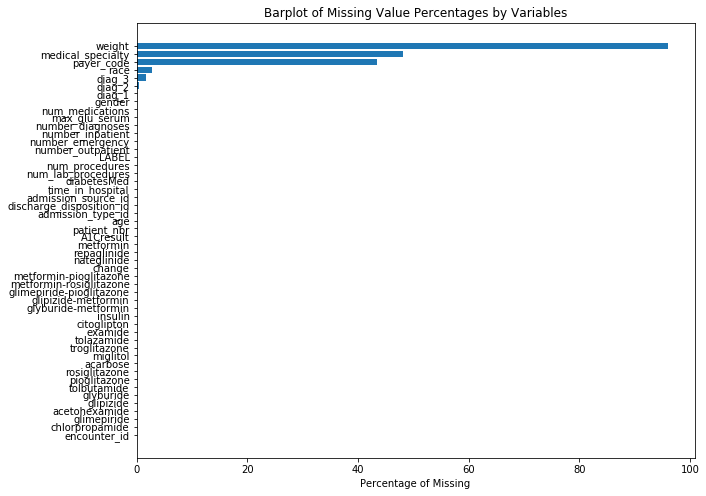

In [9]:
# plot the missing data
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing.sort_values('na_percent',inplace=True)
plt.barh(missing['column'], width=missing['na_percent'])
plt.xlabel('Percentage of Missing')
plt.title('Barplot of Missing Value Percentages by Variables')
plt.show()

In [10]:
# check missing values in rows
(df.isnull().sum(axis=1)*100/df.shape[1]).sort_values(ascending=False)[:30]

54358    10.0
62371    10.0
2163     10.0
2794     10.0
29864    10.0
81437    10.0
15752    10.0
3927     10.0
23870    10.0
14355    10.0
48002    10.0
7160     10.0
24636    10.0
6538     10.0
48361    10.0
23737    10.0
23475    10.0
9351     10.0
14851    10.0
66       10.0
15444    10.0
11893    10.0
46031    10.0
8454     10.0
9799      8.0
3038      8.0
90982     8.0
54        8.0
8500      8.0
9004      8.0
dtype: float64

In [11]:
# dropping columns with high NA percentage (>30%)
df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1, inplace=True)

In [12]:
# check missing values in rows after dropping columns
(df.isnull().sum(axis=1)*100/df.shape[1]).sort_values(ascending=False)[:20]

28054    6.382979
28588    6.382979
23737    6.382979
27815    6.382979
29864    6.382979
81437    6.382979
33771    6.382979
25157    6.382979
67136    6.382979
36050    6.382979
32389    6.382979
34145    6.382979
27557    6.382979
29358    6.382979
78593    4.255319
19312    4.255319
51743    4.255319
12796    4.255319
31436    4.255319
29349    4.255319
dtype: float64

In [13]:
df.shape

(69973, 47)

### 5. Check outliers (numerical variables)

There are 8 numerical varaibles that will be check for outliers. There are no missing values but there are outliers in those 8 variables according to the boxplot of each numerical variable. Currently keep all those outliers in each variable

In [14]:
vars_num = ['time_in_hospital', 'num_procedures', 'number_diagnoses', 'num_medications', 
            'number_outpatient', 'number_inpatient','number_emergency', 'num_lab_procedures']

In [15]:
# there are no missing values in those 8 numerical varialbes
df[vars_num].isnull().sum()

time_in_hospital      0
num_procedures        0
number_diagnoses      0
num_medications       0
number_outpatient     0
number_inpatient      0
number_emergency      0
num_lab_procedures    0
dtype: int64

In [16]:
# a function to boxplot numerical columns
def bplot(df, cols):
    bpltdat = pd.melt(df, id_vars=['encounter_id'], 
                      value_vars = cols)
    bplot = sns.boxplot(y='value', x='variable', 
                        data=bpltdat, width=0.5, 
                        palette="colorblind")
    bplot.set_title('Boxplot of ' + ', '.join(cols))
    bplot.set_xlabel('')
    plt.show()

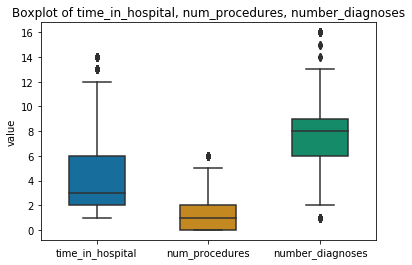

In [17]:
bplot(df, ['time_in_hospital', 'num_procedures', 'number_diagnoses'])

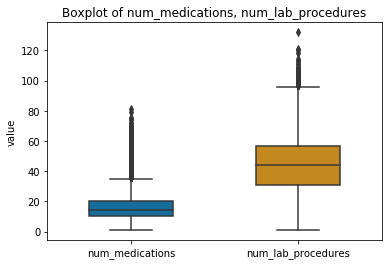

In [18]:
bplot(df, ['num_medications', 'num_lab_procedures'])

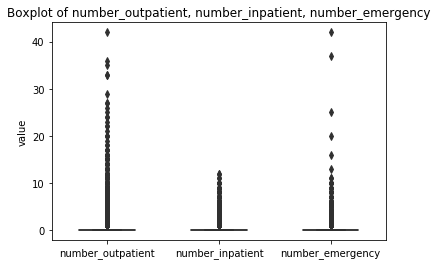

In [19]:
bplot(df, ['number_outpatient', 'number_inpatient','number_emergency'])

### 6. Examine categorical variables

There are several types of categorical variables:
 - `race`, `gender`, `age`. Those are basic demographic information.
 - `admission_type_id`, `discharge_disposition_id`, `admission_source_id` are numerical but they are IDs and should be treated as categorical.
 - `diag_1`, `diag_2`, `diag_3` have several hundred distinct values. Those could be dropped for analysis. Those diagnose information are partly captured in numerical variable `number_diagnoses`.
 - `max_glu_serum`, `A1Cresult`. Special lab test results.
 - 23 generic medications and a special one `diabetesMed`. `change` is a binary variable indicating whether there was a change in diabetic medications (either dosage or generic name).

`age` is a categorical variable but in order. It is better to covert it to numerical variable.

In [20]:
df['age'] = df['age'].str[1:].str.split('-', expand=True)[0]
#df['age'] = df['age'].astype(int)

In [21]:
# convert numerical varialbes to categorical variable
df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].astype('object')

In [22]:
def get_cat_levels(col):
    return pd.DataFrame({'Variable': [col], 'Levels': [len(df[col].unique())]})

In [23]:
# lsit of categorical variables and their number of levels
vars_cat = df.columns.values[(df.dtypes == 'object').values]
pd.concat(map(get_cat_levels, vars_cat), axis=0).sort_values(by=['Levels'], ascending=False)

,Variable,Levels
0,diag_3,757
0,diag_2,724
0,diag_1,695
0,discharge_disposition_id,21
0,admission_source_id,17
0,age,10
0,admission_type_id,8
0,race,6
0,glimepiride,4
0,glyburide-metformin,4


In [24]:
# drop variables with only 1 level
df.drop(['citoglipton', 'glimepiride-pioglitazone', 'examide'], axis=1, inplace=True)

**Categorization of diagnoses**: The dataset contained upto three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, these diagnosis codes were grouped into 9 disease groups based on the original publication using this dataset. These 9 groups are *Circulatory*, *Respiratory*, *Digestive*, *Diabetes*, *Injury*, *Musculoskeletal*, *Genitourinary*, *Neoplasms*, and *Others*. 

In [25]:
def replace_value(x):
    if  (x in range(350,460)) or x == 785:
        return 'Circulatory'
    elif (x in range(460,520)) or x == 786:
        return 'Respiratory'
    elif (x in range(520,580)) or x == 787:
        return 'Digestive'
    elif (x in range(800,1000)):
        return 'Injury'
    elif (x in range(710,740)):
        return 'Musculoskeletal'
    elif (x in range(580,630)) or x == 788:
        return 'Genitourinary'
    elif (x in range(140,240)):
        return 'Neoplasms'
    elif x > 250 and x < 251:
        return 'Diabetes'
    else:
        return 'Other'
    
def replace_diag(df, col):
    df.loc[df[col].str.contains('V', na = False), [col]] = 0
    df.loc[df[col].str.contains('E', na = False), [col]] = 0
    df[col] = df[col].astype(float)    
    df[col] = df[col].apply(replace_value)   

In [26]:
# re-group values of variables diag_1,diag_2,diag_3
replace_diag(df=df, col='diag_1')
replace_diag(df=df, col='diag_2')
replace_diag(df=df, col='diag_3')
print(df.diag_1.value_counts(), '\n')
print(df.diag_2.value_counts(), '\n')
print(df.diag_3.value_counts())

Circulatory        21700
Other              12016
Respiratory         9486
Digestive           6487
Diabetes            5548
Injury              4694
Musculoskeletal     4064
Genitourinary       3440
Neoplasms           2538
Name: diag_1, dtype: int64 

Other              23123
Circulatory        22321
Respiratory         6925
Genitourinary       5328
Diabetes            4704
Digestive           2854
Injury              1824
Neoplasms           1599
Musculoskeletal     1295
Name: diag_2, dtype: int64 

Other              29658
Circulatory        21431
Respiratory         4650
Genitourinary       4047
Diabetes            3566
Digestive           2699
Injury              1409
Musculoskeletal     1368
Neoplasms           1145
Name: diag_3, dtype: int64


In [27]:
vars_cat = list(df.columns.values[(df.dtypes == 'object').values])[:-1]
len(vars_cat) # number of categorical variables, don't count on LABEL

33

In [28]:
# drop encounter_id and patient_nbr, they are unique now for idenfication
df.drop(['patient_nbr'], axis=1, inplace=True)

In [29]:
df.shape

(69973, 43)

In [30]:
# Count for each value in medication columns
med_col = df.iloc[:,19:39].apply(pd.value_counts).T
med_col

,>7,>8,Down,No,None,Norm,Steady,Up
A1Cresult,2865.0,6239.0,NaN,NaN,57128.0,3741.0,NaN,NaN
metformin,NaN,NaN,435.0,55070.0,NaN,NaN,13634.0,834.0
repaglinide,NaN,NaN,28.0,69056.0,NaN,NaN,818.0,71.0
nateglinide,NaN,NaN,8.0,69482.0,NaN,NaN,467.0,16.0
chlorpropamide,NaN,NaN,1.0,69902.0,NaN,NaN,66.0,4.0
glimepiride,NaN,NaN,136.0,66276.0,NaN,NaN,3331.0,230.0
acetohexamide,NaN,NaN,NaN,69972.0,NaN,NaN,1.0,NaN
glipizide,NaN,NaN,371.0,60966.0,NaN,NaN,8063.0,573.0
glyburide,NaN,NaN,418.0,62198.0,NaN,NaN,6744.0,613.0
tolbutamide,NaN,NaN,NaN,69956.0,NaN,NaN,17.0,NaN


### 7. Summary

The cleaned data set has 43 variables:
 - **1** unique encounter id
 - **1** response variable
 - **8** numerical variables
 - **33** categorical variables

In [31]:
file_name = 'data/diabetic_data_clean.csv'
df.to_csv(file_name, index=False)